#A simple autoencoder test
Bottleneck consists of a single number, which determines the fraction of the image covered in black squares

In [1]:
import numpy as np

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

from matplotlib import pyplot as plt

tf.estimator package not installed.
tf.estimator package not installed.


In [2]:
# Decoder goes here
N_image = 28 # Size of (square) input image

def regions(x):
    # x represents the fraction of the image full of ones
    img = np.zeros(N_image*N_image).reshape(N_image,N_image)
    Q = int(np.floor(x*N_image))
    img[:,0:Q] = 1
    return img

In [3]:
# And here's a test to see that the decoder does what we expect:
plt.imshow(regions(0.1))

In [4]:
#Making dataset
N_train = 1000
noise = 0.3

train_images = []
train_labels = []
for i in range(N_train):
    x = np.random.uniform()
    train_labels.append(np.int(np.round(x,1)*10))
    img = regions(x) + np.random.normal(0,noise,N_image*N_image).reshape(N_image,N_image)
    train_images.append(img)

train_images = np.array(train_images)
train_images = train_images.reshape(N_train,N_image,N_image,1)
train_labels = np.array(train_labels)

In [5]:
train_images.shape

(1000, 28, 28, 1)

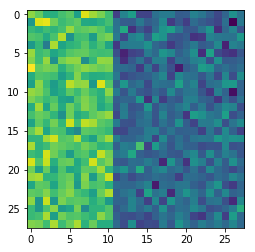

In [27]:
# And here's a test to check that the training images are reasonable:
plt.imshow(train_images[3,:,:,0])
plt.show()

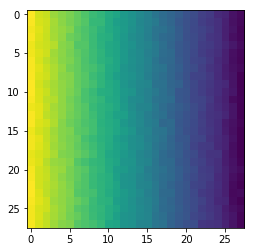

In [26]:
plt.imshow(np.mean(train_images,axis=0)[:,:,0])
plt.show()

In [8]:
from __future__ import division

def normalize_meanstd(a, axis=None):
    # axis param denotes axes along which mean & std reductions are to be performed
    mean = np.mean(a, axis=axis, keepdims=True)
    std = np.sqrt(((a - mean)**2).mean(axis=axis, keepdims=True))
    return (a - mean) / std, mean, std

train_images_std, mean, std = normalize_meanstd(train_images, axis=(1,2))

In [9]:
#Lambda Layer (Decoder)
def make_regions(x):
    img = tf.to_float(tf.convert_to_tensor(np.repeat(np.arange(N_image),N_image).reshape(N_image,N_image)))
    #np.zeros(N_image*N_image).reshape(N_image,N_image)
    #Q = tf.math.int(tf.math.floor(x*N_image))#int(np.floor(x*N_image))
    #condi = tf.math.greater(img, x)
    unity = tf.convert_to_tensor(np.repeat(1., N_image*N_image).reshape(N_image, N_image))
    zeros = tf.convert_to_tensor(np.zeros(N_image*N_image).reshape(N_image, N_image))
    tf.where(img > x, unity, zeros)
    return img

In [10]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding="same", input_shape = (N_image,N_image,1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding="same"))

model.add(layers.Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(layers.UpSampling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(layers.UpSampling2D((2, 2)))
model.add(layers.Conv2D(1, (3, 3), activation='sigmoid', padding="same"))

#model.add(layers.Flatten())
#model.add(layers.Dense(64, activation='relu'))
#model.add(layers.Dense(1))
#model.add(layers.Lambda(make_regions))

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 64)        0         
__________

In [12]:
model.compile(optimizer='RMSprop',
              loss='mean_squared_error',
              metrics=['accuracy']
             )
#model.compile(optimizer='adam',
#              loss='sparse_categorical_crossentropy',
#              metrics=['accuracy'])


In [13]:
model.fit(train_images, train_images, epochs=5)

Epoch 1/5
1000/1000 [==============================] - 6s 6ms/step - loss: 5.0829 - acc: 0.0000e+00
Epoch 2/5
1000/1000 [==============================] - 6s 6ms/step - loss: 3.2899 - acc: 0.0000e+00
Epoch 3/5
1000/1000 [==============================] - 6s 6ms/step - loss: 3.0928 - acc: 0.0000e+00
Epoch 4/5
1000/1000 [==============================] - 5s 5ms/step - loss: 2.9385 - acc: 0.0000e+00
Epoch 5/5
1000/1000 [==============================] - 6s 6ms/step - loss: 3.0241 - acc: 0.0000e+00


In [42]:
test_img = regions(0.3).reshape(28,28,1) + np.random.normal(0,noise,N_image*N_image).reshape(N_image,N_image,1)
test_img = test_img[:,:,0].transpose().reshape(28,28,1)
out = model.predict(np.array([test_img]))

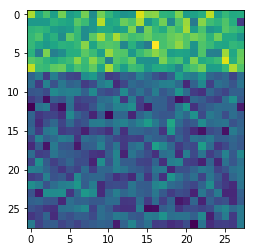

In [43]:
plt.imshow(test_img[:,:,0])
plt.show()

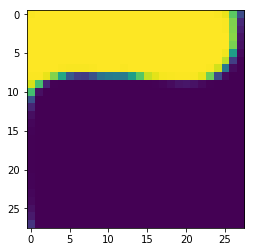

In [44]:
plt.imshow(out[0,:,:,0])
plt.show()

In [191]:
#Lambda Layer (Decoder) (TL's copy):
def make_regions(x):
    x_int = x[1]
    print x, tf.to_float(x_int)
    img = np.zeros(N_image*N_image).reshape(N_image,N_image)
    Q = int(np.floor(x_int*N_image))
    img[:,0:Q] = 1
    return img

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='softmax'))
model.add(layers.Lambda(make_regions))

In [70]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                36928     
__________

In [5]:
# Here's the mnist train data, for reference:

#mnist_data = np.load('mnist.npz')
#(train_images, train_labels), (test_images, test_labels) = (mnist_data['x_train'], mnist_data['y_train']), (mnist_data['x_test'], mnist_data['y_test'])

In [6]:
train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0


In [66]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [15]:
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 3, 64)          36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [18]:
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                36928     
__________

In [19]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_images, train_labels, epochs=5)

Epoch 1/5
 2400/60000 [>.............................] - ETA: 3:03 - loss: 1.0760 - acc: 0.6562

60000/60000 [==============================] - 134s 2ms/step - loss: 0.0197 - acc: 0.9940


In [23]:
model.predict_classes(np.array([test_images[0]]))

array([7])

In [24]:
test_labels[0]

7

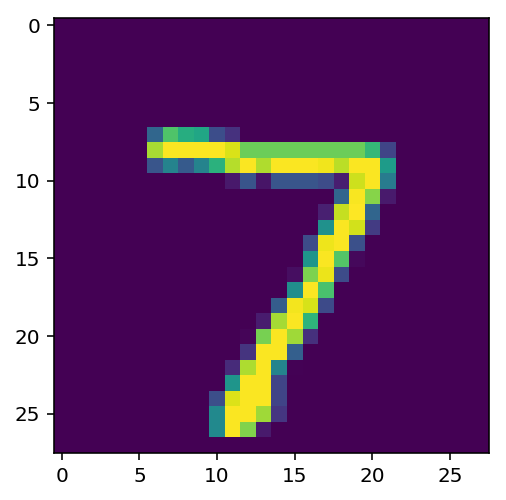

In [28]:
import matplotlib.pyplot as plt
plt.imshow(test_images[0][:,:,0])